# Clustering cities depending on their most common features

## 1. Imports and such things

Use pandas to handle dataframes

In [1]:
import pandas as pd

Use Scikit-learn to do clustering

In [22]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics

Use matplotlib to create a graph to find optimal k

In [26]:
import matplotlib.pyplot as plt

## 2. Import dataframes from notebook 1

This dataframe contains Cities, with their nation, population, Wikipedia URL, Latitude and Longitude

In [3]:
df_cities = pd.read_pickle('cities.pickle')
df_cities.head()

,City,Nation,Population,URL,Latitude,Longitude
0,Chongqing,China,30751600,https://en.wikipedia.org/wiki/Chongqing,29.558333,106.566667
1,Shanghai,China,24256800,https://en.wikipedia.org/wiki/Shanghai,31.228611,121.474722
2,Delhi,India,11034555,https://en.wikipedia.org/wiki/Delhi,28.610000,77.230000
3,Beijing,China,21516000,https://en.wikipedia.org/wiki/Beijing,39.916667,116.383333
4,Dhaka,Bangladesh,14399000,https://en.wikipedia.org/wiki/Dhaka,23.716111,90.396111


This dataframe contains a long list of the top pick venues according to Foursquare in those cities 

In [4]:
df_venues = pd.read_pickle('venues.pickle')
df_venues.head()

,City,Nation,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chongqing,China,The Harp Irish Pub,29.565116,106.575310,Bar
1,Chongqing,China,Hyatt Regency Chongqing (重庆富力凯悦酒店),29.583032,106.532228,Hotel
2,Chongqing,China,一棵树,29.548330,106.598140,Scenic Lookout
3,Chongqing,China,The Cactus,29.565164,106.575347,Mexican Restaurant
4,Chongqing,China,重庆国泰艺术中心 Cathay Pacific Art Centre,29.563591,106.574421,Public Art


This dataframe contains a left join of the previous two

In [5]:
df_joined = pd.read_pickle('joined.pickle')
df_joined.head()

,City,Nation,Venue,Venue Latitude,Venue Longitude,Venue Category,Population,URL,Latitude,Longitude
0,Chongqing,China,The Harp Irish Pub,29.565116,106.575310,Bar,30751600,https://en.wikipedia.org/wiki/Chongqing,29.558333,106.566667
1,Chongqing,China,Hyatt Regency Chongqing (重庆富力凯悦酒店),29.583032,106.532228,Hotel,30751600,https://en.wikipedia.org/wiki/Chongqing,29.558333,106.566667
2,Chongqing,China,一棵树,29.548330,106.598140,Scenic Lookout,30751600,https://en.wikipedia.org/wiki/Chongqing,29.558333,106.566667
3,Chongqing,China,The Cactus,29.565164,106.575347,Mexican Restaurant,30751600,https://en.wikipedia.org/wiki/Chongqing,29.558333,106.566667
4,Chongqing,China,重庆国泰艺术中心 Cathay Pacific Art Centre,29.563591,106.574421,Public Art,30751600,https://en.wikipedia.org/wiki/Chongqing,29.558333,106.566667


## 3. Counting venues categories

Just as in the lectures, we want to find out what the most recommended types of venues are for each city.

We do this by first turning the venue categories in one-hot notations, and then averaging these numbers for every city.
This automatically takes care of having different amounts of venues for different cities.


In [6]:
# one hot encoding of venue category
df_venues_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add city and nation columns back to the dataframe
df_venues_onehot['City'] = df_venues['City']
df_venues_onehot['Nation'] = df_venues['Nation']

# move those column to the first column
fixed_columns = list(df_venues_onehot.columns[-2:]) + list(df_venues_onehot.columns[:-2])
df_venues_onehot = df_venues_onehot[fixed_columns]

df_venues_onehot.head()

,City,Nation,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,...,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo Exhibit
0,Chongqing,China,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Chongqing,China,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Chongqing,China,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Chongqing,China,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Chongqing,China,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. Most common venue categories per city

We can now group by city

In [7]:
df_venues_grouped = df_venues_onehot.groupby(['City','Nation']).mean().reset_index()

In [8]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [9]:
num_top_venues = 10

# create columns according to number of top venues
columns = ['City','Nation']
for ind in np.arange(num_top_venues):
    columns.append('Common Venue {}'.format(ind+1))

# create a new dataframe
df_common_venues = pd.DataFrame(columns=columns)
df_common_venues['City'] = df_venues_grouped['City']
df_common_venues['Nation'] = df_venues_grouped['Nation']

# actually perform counting
for ind in np.arange(df_venues_grouped.shape[0]):
    df_common_venues.iloc[ind, 2:] = return_most_common_venues(df_venues_grouped.iloc[ind, :], num_top_venues)

In [10]:
df_common_venues.head()

,City,Nation,Common Venue 1,Common Venue 2,Common Venue 3,Common Venue 4,Common Venue 5,Common Venue 6,Common Venue 7,Common Venue 8,Common Venue 9,Common Venue 10
0,Abidjan,Ivory Coast,Shopping Mall,Ice Cream Shop,Italian Restaurant,African Restaurant,Supermarket,Pharmacy,Bakery,Bar,Music Venue,Pizza Place
1,Abu Dhabi,United Arab Emirates,Café,Beach,Middle Eastern Restaurant,Restaurant,Indian Restaurant,Hotel,Golf Course,Italian Restaurant,Bakery,Filipino Restaurant
2,Abuja,Nigeria,Shopping Mall,Fast Food Restaurant,Lounge,African Restaurant,Department Store,Restaurant,Indian Restaurant,Fried Chicken Joint,Pizza Place,Pharmacy
3,Accra,Ghana,Shopping Mall,Café,Restaurant,American Restaurant,Beach,Grocery Store,Movie Theater,Chinese Restaurant,Snack Place,Coffee Shop
4,Addis Ababa,Ethiopia,Italian Restaurant,Ethiopian Restaurant,Pizza Place,Grocery Store,Hotel,Greek Restaurant,American Restaurant,Restaurant,Massage Studio,Fast Food Restaurant


## 5. Finding similar cities

For clustering, we use the averages for every category as found in section 3, but drop the city/nation attributes

In [20]:
df_clustering = df_venues_grouped.drop(['City', 'Nation'], 1)

### 4.1 Finding optimal value for k

We look at a silhouette score for various values of k to find an optimal one.

A first look immediately finds that 2,3,4 give better values, but I find that too few clusters.

maximum is 0.06751587640560743, which occurs at k=16


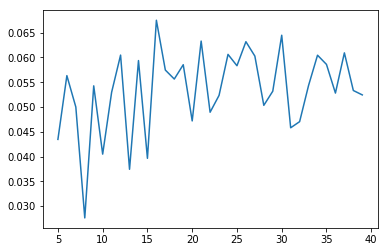

In [48]:
START = 5
END = 40
scores = []
for k in range(START, END):
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_clustering)
    
    scores.append(metrics.silhouette_score(df_clustering, kmeans.labels_))   
print( "maximum is {}, which occurs at k={}".format(np.max(scores),np.argmax(scores)+START))
plt.plot(range(START,END),scores)
kclusters=np.argmax(scores)+START

### 4.2 Clustering

We continue with $k=16$

In [49]:
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustering)

In [50]:
df_common_venues['Cluster label'] = kmeans.labels_

df_cities2 = pd.merge(df_common_venues, df_cities, how='left',
        on=['City','Nation'], validate="1:1")
df_cities2.head()

,City,Nation,Common Venue 1,Common Venue 2,Common Venue 3,Common Venue 4,Common Venue 5,Common Venue 6,Common Venue 7,Common Venue 8,Common Venue 9,Common Venue 10,Cluster label,Population,URL,Latitude,Longitude
0,Abidjan,Ivory Coast,Shopping Mall,Ice Cream Shop,Italian Restaurant,African Restaurant,Supermarket,Pharmacy,Bakery,Bar,Music Venue,Pizza Place,9,4765000,https://en.wikipedia.org/wiki/Abidjan,5.316667,-4.033333
1,Abu Dhabi,United Arab Emirates,Café,Beach,Middle Eastern Restaurant,Restaurant,Indian Restaurant,Hotel,Golf Course,Italian Restaurant,Bakery,Filipino Restaurant,3,1145000,https://en.wikipedia.org/wiki/Abu_Dhabi,24.466667,54.366667
2,Abuja,Nigeria,Shopping Mall,Fast Food Restaurant,Lounge,African Restaurant,Department Store,Restaurant,Indian Restaurant,Fried Chicken Joint,Pizza Place,Pharmacy,9,1235880,https://en.wikipedia.org/wiki/Abuja,9.066667,7.483333
3,Accra,Ghana,Shopping Mall,Café,Restaurant,American Restaurant,Beach,Grocery Store,Movie Theater,Chinese Restaurant,Snack Place,Coffee Shop,9,2070463,https://en.wikipedia.org/wiki/Accra,5.550000,-0.200000
4,Addis Ababa,Ethiopia,Italian Restaurant,Ethiopian Restaurant,Pizza Place,Grocery Store,Hotel,Greek Restaurant,American Restaurant,Restaurant,Massage Studio,Fast Food Restaurant,5,3103673,https://en.wikipedia.org/wiki/Addis_Ababa,9.030000,38.740000


## 5. Export the results

In [51]:
df_cities2.to_csv('cities2.csv')
df_cities2.to_pickle('cities2.pickle')